In [1]:
!pip install etsformer-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from etsformer_pytorch import ETSFormer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold

In [4]:
def setup_ETSformer():
    model = ETSFormer(
        time_features=1,
        model_dim=128,  
        embed_kernel_size=3,
        layers=2,  
        heads=4,  
        K=1,
        dropout=0.2,
    )
    return model

In [5]:

df = pd.read_csv("../input/timeseries/finalData.csv")

data = torch.tensor(df["TSLA High"].values, dtype=torch.float).reshape(-1, 1)

# Cross-validation setup
kf = KFold(n_splits=5)
epochs = 50  
learning_rate = 0.001
batch_size = 64

cv_train_losses = []
cv_val_losses = []
all_val_labels = []
all_val_preds = []

In [6]:
for fold, (train_idx, val_idx) in enumerate(kf.split(data)):
    train, val = data[train_idx], data[val_idx]

    train_dataset = TensorDataset(train[:-len(val)], train[len(val):])
    val_dataset = TensorDataset(train[:-len(val)], train[len(val):])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = setup_ETSformer()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        for batch in train_loader:
            batch_train, batch_val = batch
            optimizer.zero_grad()
            train_pred = model(torch.reshape(batch_train, (1, -1, 1)), num_steps_forecast=batch_val.shape[0])
            train_loss = criterion(train_pred[:, :batch_train.shape[0], :], torch.reshape(batch_train, (1, -1, 1)))
            train_loss.backward()
            optimizer.step()
            epoch_train_loss += train_loss.item()

        train_losses.append(epoch_train_loss / len(train_loader))
        
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch_train, batch_val = batch
                val_pred = model(torch.reshape(batch_train, (1, -1, 1)), num_steps_forecast=batch_val.shape[0])
                val_loss = criterion(val_pred[:, :batch_val.shape[0], :], torch.reshape(batch_val, (1, -1, 1)))
                epoch_val_loss += val_loss.item()
                all_val_labels.extend(batch_val.numpy().flatten())
                all_val_preds.extend(val_pred[:, :batch_val.shape[0], :].numpy().flatten())
        
        val_losses.append(epoch_val_loss / len(val_loader))
    
    cv_train_losses.append(train_losses)
    cv_val_losses.append(val_losses)

    print(f"Fold {fold+1}/{kf.n_splits} - Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

Fold 1/5 - Train Loss: 3570.3514, Validation Loss: 12363.8422
Fold 2/5 - Train Loss: 9985.7964, Validation Loss: 30234.8394
Fold 3/5 - Train Loss: 10260.9181, Validation Loss: 24206.1205
Fold 4/5 - Train Loss: 9896.1793, Validation Loss: 20635.1537
Fold 5/5 - Train Loss: 10361.4950, Validation Loss: 28117.6299


In [7]:
avg_train_losses = [sum(fold_losses) / len(cv_train_losses) for fold_losses in zip(*cv_train_losses)]
avg_val_losses = [sum(fold_losses) / len(cv_val_losses) for fold_losses in zip(*cv_val_losses)]

# Convert to binary labels for ROC curve
threshold = data.mean().item()  # Example threshold: mean of all data
binary_labels = [1 if val > threshold else 0 for val in all_val_labels]
binary_preds = [1 if pred > threshold else 0 for pred in all_val_preds]

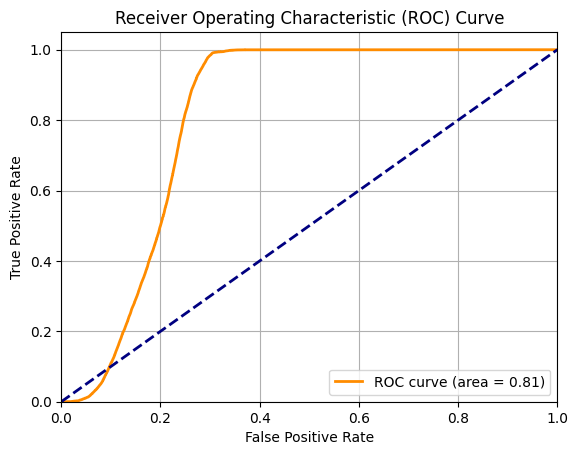

In [8]:
fpr, tpr, _ = roc_curve(binary_labels, all_val_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [9]:
model.eval()
with torch.no_grad():
    pred = model(torch.reshape(data, (1, -1, 1)), num_steps_forecast=len(val))
pred = torch.reshape(pred[:, len(train):], (-1,)).detach().numpy()

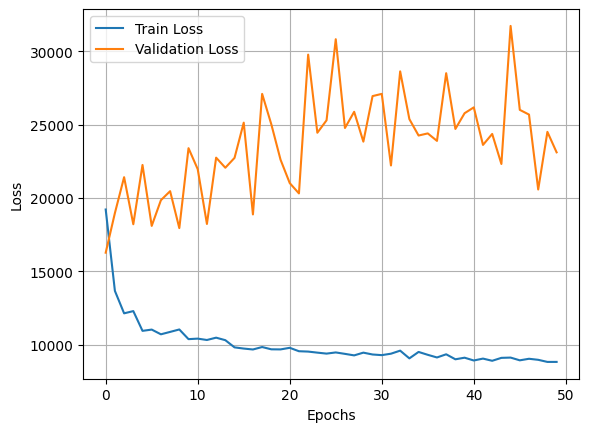

In [10]:
plt.plot(range(epochs), avg_train_losses, label='Train Loss')
plt.plot(range(epochs), avg_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()